Reading /data/Dokumentos/VUT/3MIT/BRIa/project/measure-2025-11-26_22:25:12-epo.fif ...
    Found the data of interest:
        t =       0.00 ...   20998.00 ms
        0 CTF compensation matrices available
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
n_epochs = 2


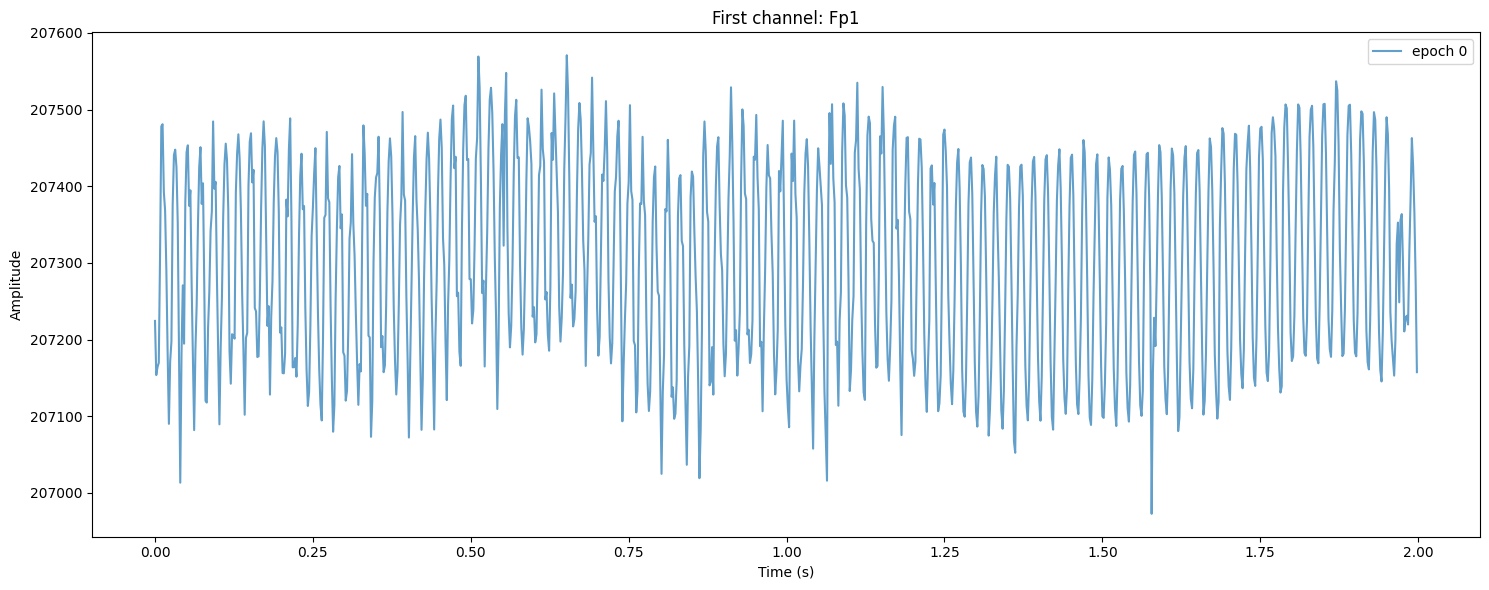

In [3]:

import mne
import numpy as np
epochs = mne.read_epochs("measure-2025-11-26_22:25:12-epo.fif", preload=True)
# epochs.plot(scalings="auto", show=True)
X = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
first_channel_data = X[:, 1, 2000:3000]  # Data for the first channel across all epochs

# l_freq, h_freq = 0.5, 40.0
# first_channel_data = mne.filter.filter_data(first_channel_data, 500, l_freq, h_freq, fir_design='firwin')


import matplotlib.pyplot as plt

n_epochs, n_times = first_channel_data.shape
print(f"{n_epochs = }")
times = np.arange(n_times) / float(epochs.info['sfreq'])

plt.figure(figsize=(15, 6))
for i in range(1):
    plt.plot(times, first_channel_data[i], alpha=0.7, label=f'epoch {i}' if n_epochs <= 10 else None)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'First channel: {epochs.ch_names[0]}')
if n_epochs <= 10:
    plt.legend()
plt.tight_layout()
plt.show()